## Basic Initial Strategy Setup:
1. Perform Long Small Cap-Short Large Cap beta neutral 3M backtest strategy as benchmark (although it will be most likely pretty shitty)
2. Then perform a Long Small Cap-Short Large Cap- Long Weighted Mag 7 beta neutral strategy (In order to not have the effects of the MegaCaps)

In [1]:
import pandas as pd
import yfinance as yf 
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# --- Parameters ---
start_date = "2024-03-08"  # Rebalance day
end_date   = "2024-09-09"  #  6 Months later
sp500_ticker = "^GSPC"     # S&P 500 Index
sp600_ticker = "^SP600"    # S&P 600 Small Cap

# --- 1. Download Price Data ---
sp500_data = yf.download(sp500_ticker, start=start_date, end=end_date)["Adj Close"]
sp600_data = yf.download(sp600_ticker, start=start_date, end=end_date)["Adj Close"]

# --- 2. Calculate Daily Returns ---
sp500_returns = sp500_data.pct_change().dropna()
sp600_returns = sp600_data.pct_change().dropna()

# Align the returns DataFrames (in case of mismatched trading days)
returns_df = pd.DataFrame({
    'SP500': sp500_returns,
    'SP600': sp600_returns
}).dropna()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
# --- 3. Linear Regression to Estimate Beta ---
X = sm.add_constant(returns_df['SP500'])  # Add intercept
y = returns_df['SP600']
model = sm.OLS(y, X).fit()
beta = model.params['SP500']

print("Regression Results:")
print(model.summary())
print(f"\nEstimated Beta: {beta:.4f}\n")

Regression Results:
                            OLS Regression Results                            
Dep. Variable:                  SP600   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     115.3
Date:                Wed, 29 Jan 2025   Prob (F-statistic):           2.22e-19
Time:                        12:57:28   Log-Likelihood:                 412.73
No. Observations:                 125   AIC:                            -821.5
Df Residuals:                     123   BIC:                            -815.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001

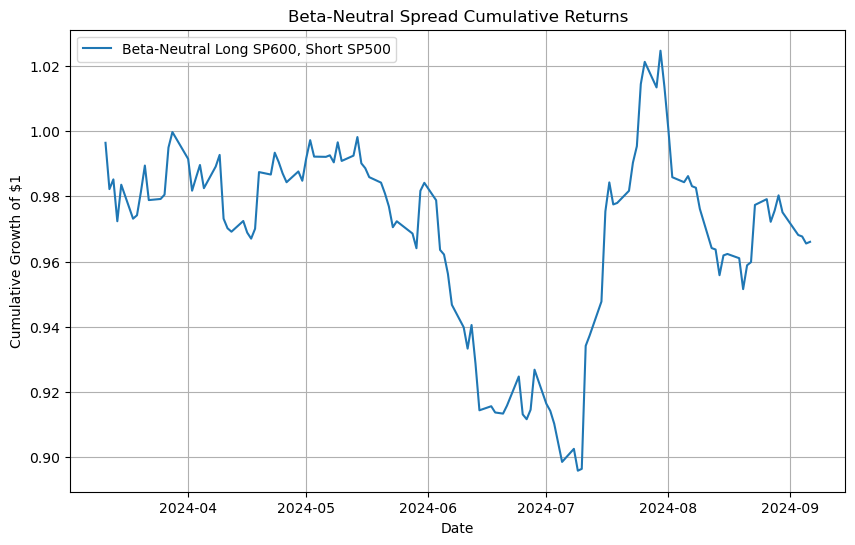

In [6]:
# --- 4. Construct Beta-Neutral Strategy Returns ---
# Strategy return on each day = SP600_return - beta * SP500_return
strategy_returns = returns_df['SP600'] - (beta) * returns_df['SP500'] 

# --- 5. Backtest: Cumulative Performance of the Spread ---
# Assuming $1 initial capital in the spread
cumulative_performance = (1 + strategy_returns).cumprod()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(cumulative_performance, label='Beta-Neutral Long SP600, Short SP500')
plt.title('Beta-Neutral Spread Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Growth of $1')
plt.legend()
plt.grid(True)
plt.show()

## Observations
1. Dogshit strategy (obviously because of the amazing performance of Mag7)
2. Lets try now "Hedging" the effects of Mag7

In [7]:
# --- 1) Read in Mag7 file and set up date index ---
mag7_df = pd.read_csv("SP500_returns_output.csv", usecols=["Dates","Mag7_Ret Cap weighted"])
# Convert date column to DateTime
mag7_df["Dates"] = pd.to_datetime(mag7_df["Dates"])
# Make "Dates" the index
mag7_df.set_index("Dates", inplace=True)
# Rename the return column
mag7_df.rename(columns={"Mag7_Ret Cap weighted": "Mag7"}, inplace=True)

# Convert mag7_df (1-column DataFrame) to a Series
mag7_series = mag7_df["Mag7"]
# Optionally confirm name
mag7_series.name = "Mag7"

# --- 2) Align / Merge All Returns by Date ---
returns_df = pd.concat(
    [
        sp600_returns.rename("SP600"),  # already a Series
        sp500_returns.rename("SP500"),  # already a Series
        mag7_series                     # now a Series too
    ],
    axis=1
).dropna()

Multi-Factor Regression Results:
                            OLS Regression Results                            
Dep. Variable:                  SP600   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     138.9
Date:                Wed, 29 Jan 2025   Prob (F-statistic):           3.61e-32
Time:                        13:03:22   Log-Likelihood:                 445.58
No. Observations:                 125   AIC:                            -885.2
Df Residuals:                     122   BIC:                            -876.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.00

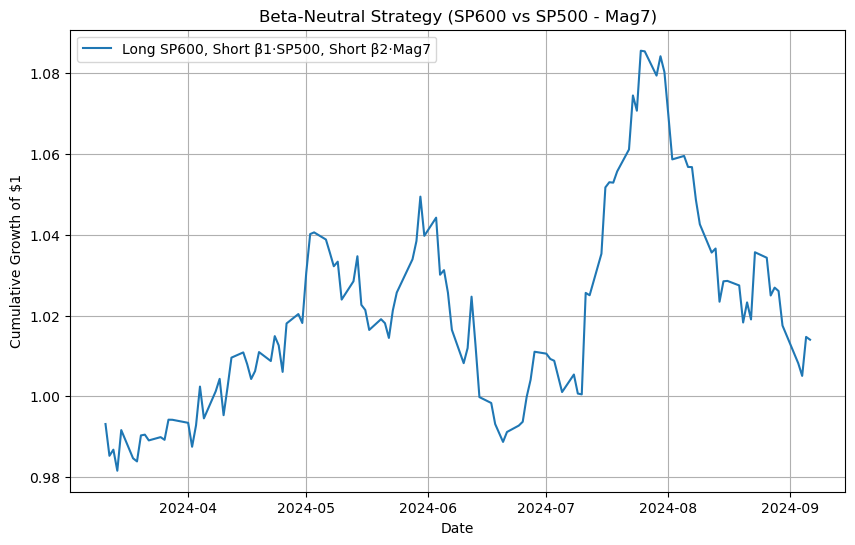

In [8]:
# -----------------------------------------
# 2) Multi-Factor Regression:
#    SP600(t) = α + β1 * SP500(t) + β2 * Mag7(t) + ε(t)
# -----------------------------------------
X = sm.add_constant(returns_df[['SP500', 'Mag7']])  # Add intercept
y = returns_df['SP600']

model = sm.OLS(y, X).fit()
beta_sp500 = model.params['SP500']
beta_mag7  = model.params['Mag7']

print("Multi-Factor Regression Results:")
print(model.summary())
# -----------------------------------------
# 3) Construct a Market-Neutral Strategy
#    Strategy Return = SP600 - β1 * SP500 - β2 * Mag7
# -----------------------------------------
strategy_returns = returns_df['SP600'] \
                   - beta_sp500 * returns_df['SP500'] \
                   - beta_mag7  * returns_df['Mag7']

# -----------------------------------------
# 4) Backtest: Calculate Cumulative Performance
# -----------------------------------------
cumulative_performance = (1 + strategy_returns).cumprod()

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(cumulative_performance, label='Long SP600, Short β1·SP500, Short β2·Mag7')
plt.xlabel('Date')
plt.ylabel('Cumulative Growth of $1')
plt.title('Beta-Neutral Strategy (SP600 vs SP500 - Mag7)')
plt.legend()
plt.grid(True)
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
=== Strategy A Regression ===
                            OLS Regression Results                            
Dep. Variable:                  SP600   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     115.3
Date:                Wed, 29 Jan 2025   Prob (F-statistic):           2.22e-19
Time:                        13:10:33   Log-Likelihood:                 412.73
No. Observations:                 125   AIC:                            -821.5
Df Residuals:                     123   BIC:                            -815.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          

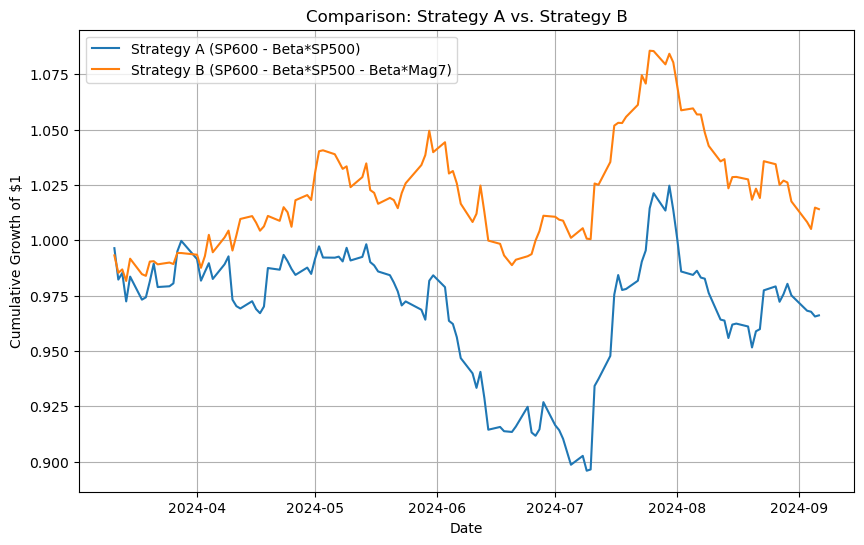

In [12]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# 0) Download Data (Replace Tickers/Dates as Needed)
#    We'll do a minimal example; adapt to your actual code.
# ------------------------------------------------------------------------------
start_date = "2024-03-08"
end_date = "2024-09-09"

sp500 = yf.download("^GSPC", start=start_date, end=end_date)["Adj Close"]
sp600 = yf.download("^SP600", start=start_date, end=end_date)["Adj Close"]

# Suppose mag7_df already read from CSV; now a 1-col DataFrame or Series indexed by date
# e.g. mag7_series = mag7_df["Mag7"]

# Convert to daily returns
sp500_returns = sp500.pct_change().dropna()
sp600_returns = sp600.pct_change().dropna()

# Ensure alignment
df = pd.concat([sp500_returns.rename("SP500"),
                sp600_returns.rename("SP600"),
                mag7_series.rename("Mag7")], axis=1).dropna()

# ------------------------------------------------------------------------------
# 1) Strategy A: Beta-Neutral SP600 vs. SP500 Only
# ------------------------------------------------------------------------------
# SP600(t) = alpha + beta_SP500 * SP500(t) + eps
X1 = sm.add_constant(df["SP500"])
y1 = df["SP600"]
model1 = sm.OLS(y1, X1).fit()
beta_sp500_only = model1.params["SP500"]

# Strategy A daily returns
stratA_returns = df["SP600"] - beta_sp500_only * df["SP500"]

# ------------------------------------------------------------------------------
# 2) Strategy B: Beta-Neutral SP600 vs. SP500 & Mag7
# ------------------------------------------------------------------------------
# SP600(t) = alpha + beta_SP500 * SP500(t) + beta_Mag7 * Mag7(t) + eps
X2 = sm.add_constant(df[["SP500", "Mag7"]])
y2 = df["SP600"]
model2 = sm.OLS(y2, X2).fit()
beta_sp500 = model2.params["SP500"]
beta_mag7  = model2.params["Mag7"]

# Strategy B daily returns
stratB_returns = df["SP600"] - beta_sp500 * df["SP500"] - 1*beta_mag7 * df["Mag7"]

print("=== Strategy A Regression ===")
print(model1.summary())
print("\n=== Strategy B Regression ===")
print(model2.summary())

# ------------------------------------------------------------------------------
# 3) Basic Performance Metrics Function
# ------------------------------------------------------------------------------
def performance_metrics(returns, freq=252):
    """
    Calculate annualized return, volatility, Sharpe ratio, and max drawdown.
    freq=252 for daily data, freq=52 for weekly, etc.
    """
    ann_return = returns.mean() * freq
    ann_vol    = returns.std() * np.sqrt(freq)
    sharpe     = ann_return / ann_vol if ann_vol != 0 else np.nan
    
    # Compute max drawdown
    cum_ret      = (1 + returns).cumprod()
    rolling_max  = cum_ret.cummax()
    drawdown     = (cum_ret - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    return {
        "Annualized Return": ann_return,
        "Annualized Vol": ann_vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_drawdown
    }

# ------------------------------------------------------------------------------
# 4) Compare Strategies
# ------------------------------------------------------------------------------
metricsA = performance_metrics(stratA_returns)
metricsB = performance_metrics(stratB_returns)

comparison_df = pd.DataFrame([metricsA, metricsB], index=["Strategy A", "Strategy B"])
print("\nPerformance Comparison:\n", comparison_df)

# ------------------------------------------------------------------------------
# 5) Plot Cumulative Performance
# ------------------------------------------------------------------------------
cumulativeA = (1 + stratA_returns).cumprod()
cumulativeB = (1 + stratB_returns).cumprod()

plt.figure(figsize=(10,6))
plt.plot(cumulativeA, label="Strategy A (SP600 - Beta*SP500)")
plt.plot(cumulativeB, label="Strategy B (SP600 - Beta*SP500 - Beta*Mag7)")
plt.xlabel("Date")
plt.ylabel("Cumulative Growth of $1")
plt.title("Comparison: Strategy A vs. Strategy B")
plt.legend()
plt.grid(True)
plt.show()


-0.007999089545796149

In [9]:
beta_sp500

2.280205365056003